# Actividad 1: Distribución de Poisson
## Análisis de Radiación Natural con Contador Geiger

**Objetivo:** Analizar datos de radiación natural usando distribución de Poisson

**Fecha de toma de datos:** 26 de noviembre de 2025

**Duración:** 30 minutos (180 intervalos de 10 segundos)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns

# Configuración de gráficos
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
sns.set_style('whitegrid')

## 1. Carga y Procesamiento de Datos

Los datos n_i mostrados en la página hacen referencia al **total acumulado de cuentas** hasta el momento.

Para obtener las cuentas en cada intervalo de 10s, calculamos: $\Delta n_i = n_{i+1} - n_i$

In [4]:
# Leer datos del archivo
def load_geiger_data(filename):
    """
    Carga los datos del contador Geiger desde el archivo.
    Extrae solo los valores numéricos válidos.
    """
    data = []
    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            # Intentar convertir a número
            try:
                value = int(line)
                data.append(value)
            except ValueError:
                # Ignorar líneas que no son números
                continue
    return np.array(data)

# Cargar datos acumulados
cumulative_counts = load_geiger_data('datosGeigerRadNatural_20251126.txt')

print(f"Total de datos cargados: {len(cumulative_counts)}")
print(f"Primeros 10 valores (acumulados): {cumulative_counts[:10]}")
print(f"Últimos 10 valores (acumulados): {cumulative_counts[-10:]}")

Total de datos cargados: 101
Primeros 10 valores (acumulados): [ 9 16 17 23 24 28 30 34 35 36]
Últimos 10 valores (acumulados): [377 382 388 393 396 400 402 409 417 421]


In [5]:
# Calcular las diferencias para obtener cuentas por intervalo
# Nota: El primer valor no tiene referencia anterior, se considera como primer intervalo
counts_per_interval = np.diff(cumulative_counts)

# Verificar si hay valores negativos (indica reinicio del contador)
negative_indices = np.where(counts_per_interval < 0)[0]
print(f"\nÍndices con valores negativos (reinicios): {negative_indices}")

# Eliminar valores negativos (reinicios del sistema)
counts_per_interval_clean = counts_per_interval[counts_per_interval >= 0]

print(f"\nDatos por intervalo de 10s:")
print(f"Total de intervalos: {len(counts_per_interval_clean)}")
print(f"Primeros 20 intervalos: {counts_per_interval_clean[:20]}")
print(f"\nEstadísticas iniciales:")
print(f"Mínimo: {np.min(counts_per_interval_clean)} cuentas")
print(f"Máximo: {np.max(counts_per_interval_clean)} cuentas")
print(f"Media: {np.mean(counts_per_interval_clean):.2f} cuentas")
print(f"Desviación estándar: {np.std(counts_per_interval_clean, ddof=1):.2f} cuentas")


Índices con valores negativos (reinicios): []

Datos por intervalo de 10s:
Total de intervalos: 100
Primeros 20 intervalos: [7 1 6 1 4 2 4 1 1 5 1 4 4 6 4 9 2 2 6 2]

Estadísticas iniciales:
Mínimo: 0 cuentas
Máximo: 11 cuentas
Media: 4.12 cuentas
Desviación estándar: 2.33 cuentas


## 2. Análisis Preliminar: Detección de Datos Atípicos

Usamos el método de **boxplot** y el criterio de los **cuartiles** (IQR - Interquartile Range) para identificar outliers.

**Criterio:** Un dato es atípico si:
- $x < Q_1 - 1.5 \times IQR$ 
- $x > Q_3 + 1.5 \times IQR$

donde $IQR = Q_3 - Q_1$

In [6]:
# Calcular cuartiles
Q1 = np.percentile(counts_per_interval_clean, 25)
Q2 = np.percentile(counts_per_interval_clean, 50)  # Mediana
Q3 = np.percentile(counts_per_interval_clean, 75)
IQR = Q3 - Q1

# Definir límites para outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Análisis de Cuartiles:")
print(f"Q1 (25%): {Q1:.2f}")
print(f"Q2 (50% - Mediana): {Q2:.2f}")
print(f"Q3 (75%): {Q3:.2f}")
print(f"IQR: {IQR:.2f}")
print(f"\nLímites para outliers:")
print(f"Límite inferior: {lower_bound:.2f}")
print(f"Límite superior: {upper_bound:.2f}")

# Identificar outliers
outliers = counts_per_interval_clean[(counts_per_interval_clean < lower_bound) | 
                                      (counts_per_interval_clean > upper_bound)]
outlier_indices = np.where((counts_per_interval_clean < lower_bound) | 
                            (counts_per_interval_clean > upper_bound))[0]

print(f"\nDatos atípicos encontrados: {len(outliers)}")
if len(outliers) > 0:
    print(f"Valores atípicos: {outliers}")
    print(f"Índices: {outlier_indices}")

Análisis de Cuartiles:
Q1 (25%): 2.00
Q2 (50% - Mediana): 4.00
Q3 (75%): 6.00
IQR: 4.00

Límites para outliers:
Límite inferior: -4.00
Límite superior: 12.00

Datos atípicos encontrados: 0


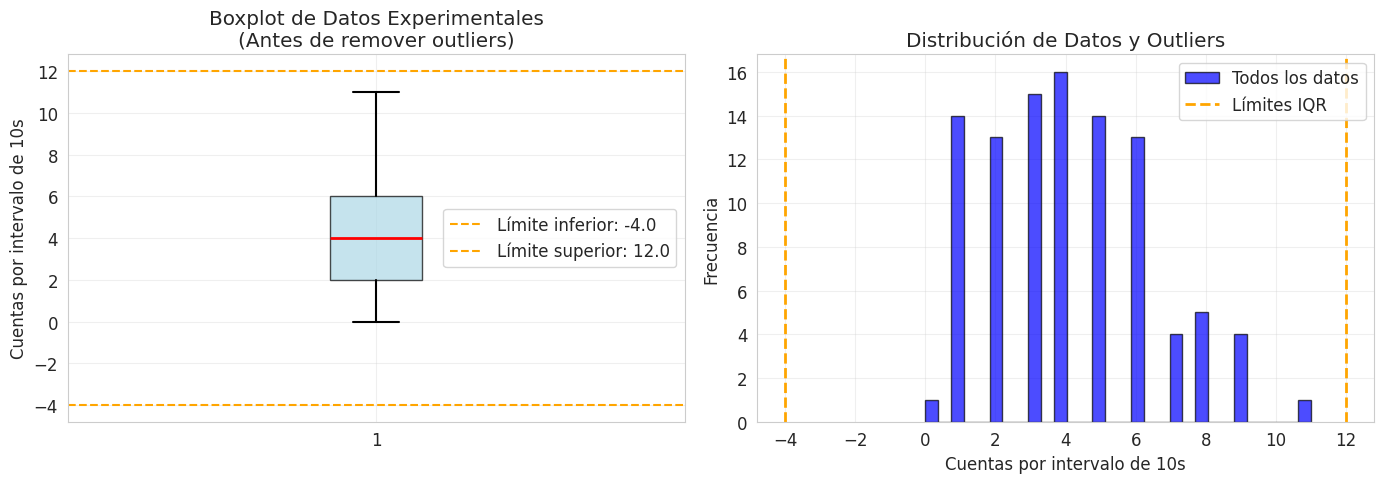

In [7]:
# Crear boxplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot vertical
bp = ax1.boxplot(counts_per_interval_clean, vert=True, patch_artist=True,
                 boxprops=dict(facecolor='lightblue', alpha=0.7),
                 medianprops=dict(color='red', linewidth=2),
                 whiskerprops=dict(linewidth=1.5),
                 capprops=dict(linewidth=1.5))

ax1.set_ylabel('Cuentas por intervalo de 10s')
ax1.set_title('Boxplot de Datos Experimentales\n(Antes de remover outliers)')
ax1.grid(True, alpha=0.3)

# Agregar líneas de referencia
ax1.axhline(y=lower_bound, color='orange', linestyle='--', linewidth=1.5, label=f'Límite inferior: {lower_bound:.1f}')
ax1.axhline(y=upper_bound, color='orange', linestyle='--', linewidth=1.5, label=f'Límite superior: {upper_bound:.1f}')
ax1.legend()

# Histograma con outliers marcados
ax2.hist(counts_per_interval_clean, bins=30, alpha=0.7, color='blue', edgecolor='black', label='Todos los datos')
if len(outliers) > 0:
    ax2.hist(outliers, bins=10, alpha=0.9, color='red', edgecolor='black', label='Outliers')
ax2.axvline(x=lower_bound, color='orange', linestyle='--', linewidth=2, label=f'Límites IQR')
ax2.axvline(x=upper_bound, color='orange', linestyle='--', linewidth=2)
ax2.set_xlabel('Cuentas por intervalo de 10s')
ax2.set_ylabel('Frecuencia')
ax2.set_title('Distribución de Datos y Outliers')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('boxplot_outliers.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
# Remover outliers
data_cleaned = counts_per_interval_clean[(counts_per_interval_clean >= lower_bound) & 
                                          (counts_per_interval_clean <= upper_bound)]

print(f"\nDatos después de remover outliers:")
print(f"Total de datos: {len(data_cleaned)}")
print(f"Datos removidos: {len(counts_per_interval_clean) - len(data_cleaned)}")
print(f"Porcentaje removido: {100*(len(counts_per_interval_clean) - len(data_cleaned))/len(counts_per_interval_clean):.2f}%")


Datos después de remover outliers:
Total de datos: 100
Datos removidos: 0
Porcentaje removido: 0.00%


## 3. Cálculo de λ y Generación de Datos Simulados

Para una distribución de Poisson, el parámetro $\lambda$ representa tanto la **media** como la **varianza**:

$$P(k; \lambda) = \frac{\lambda^k e^{-\lambda}}{k!}$$

donde $\lambda$ = número promedio de eventos por intervalo

In [10]:
# Calcular λ (lambda) - valor medio
lambda_exp = np.mean(data_cleaned)
std_exp = np.std(data_cleaned, ddof=1)
std_error_exp = std_exp / np.sqrt(len(data_cleaned))

print("Estadísticas de Datos Experimentales (sin outliers):")
print(f"λ (media): {lambda_exp:.3f} ± {std_error_exp:.3f} cuentas/10s")
print(f"Desviación estándar: {std_exp:.3f} cuentas")
print(f"Varianza: {np.var(data_cleaned, ddof=1):.3f}")
print(f"\nPara Poisson ideal: media = varianza = λ")
print(f"Razón varianza/media: {np.var(data_cleaned, ddof=1)/lambda_exp:.3f}")
print(f"(Debería ser ≈ 1 para Poisson pura)")

Estadísticas de Datos Experimentales (sin outliers):
λ (media): 4.120 ± 0.233 cuentas/10s
Desviación estándar: 2.332 cuentas
Varianza: 5.440

Para Poisson ideal: media = varianza = λ
Razón varianza/media: 1.320
(Debería ser ≈ 1 para Poisson pura)


In [11]:
# Generar datos simulados con distribución de Poisson
np.random.seed(42)  # Para reproducibilidad
n_samples = len(data_cleaned)
data_simulated = stats.poisson.rvs(mu=lambda_exp, size=n_samples)

# Estadísticas de datos simulados
lambda_sim = np.mean(data_simulated)
std_sim = np.std(data_simulated, ddof=1)

print(f"\nDatos Simulados (Poisson con λ={lambda_exp:.3f}):")
print(f"Número de muestras: {n_samples}")
print(f"Media: {lambda_sim:.3f} cuentas/10s")
print(f"Desviación estándar: {std_sim:.3f} cuentas")
print(f"Varianza: {np.var(data_simulated, ddof=1):.3f}")
print(f"Razón varianza/media: {np.var(data_simulated, ddof=1)/lambda_sim:.3f}")


Datos Simulados (Poisson con λ=4.120):
Número de muestras: 100
Media: 4.170 cuentas/10s
Desviación estándar: 2.080 cuentas
Varianza: 4.324
Razón varianza/media: 1.037


## 4. Comparación: Datos Reales vs Simulados

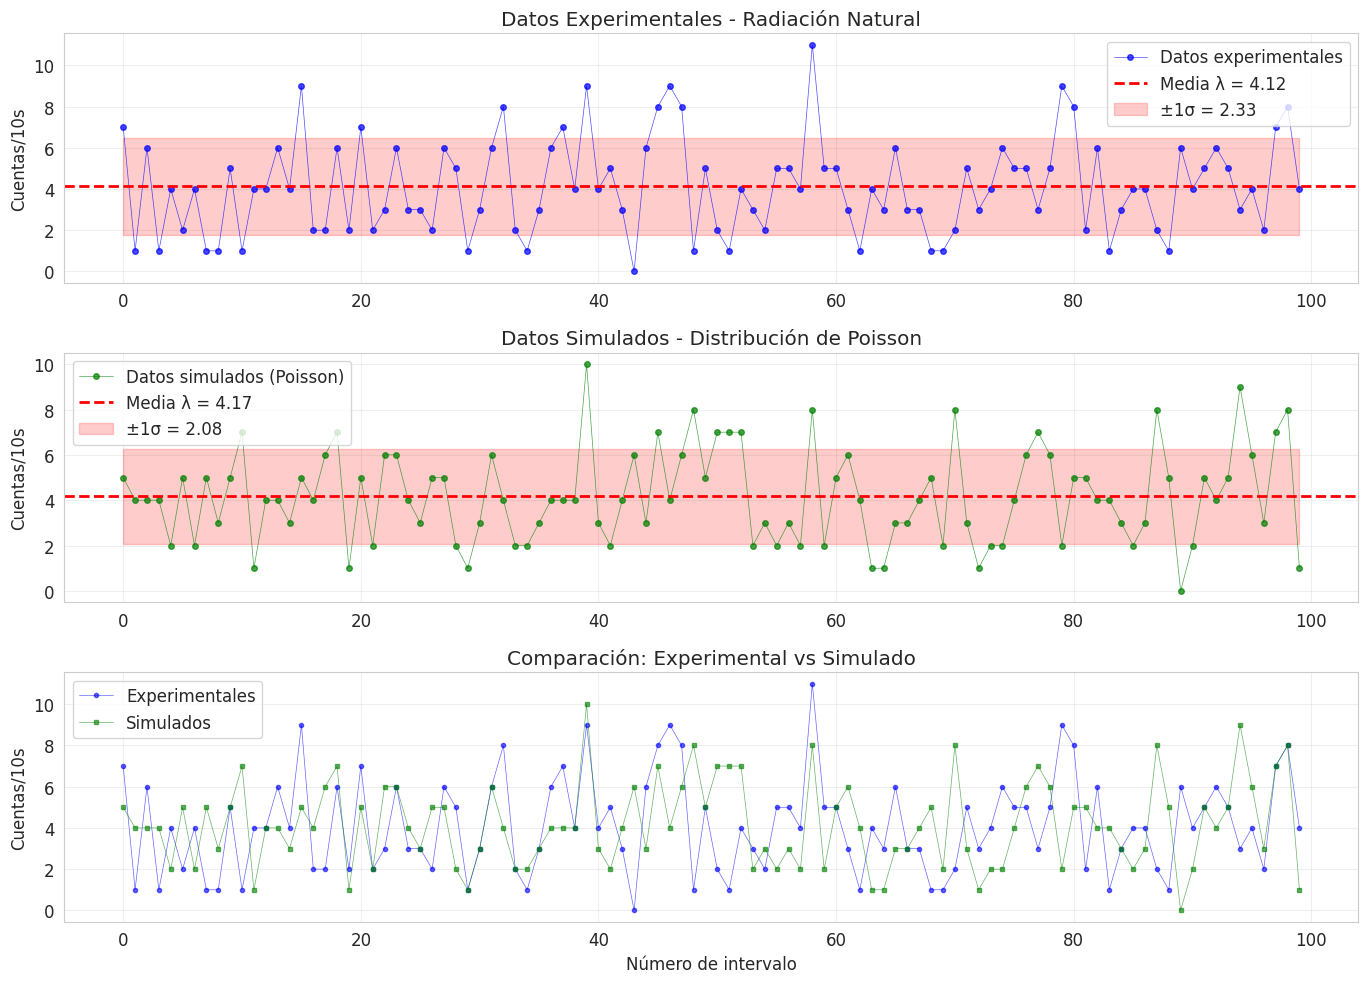

In [12]:
# Gráfico de series temporales
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10))

# Datos experimentales
ax1.plot(data_cleaned, 'o-', markersize=4, linewidth=0.5, alpha=0.7, color='blue', label='Datos experimentales')
ax1.axhline(y=lambda_exp, color='red', linestyle='--', linewidth=2, label=f'Media λ = {lambda_exp:.2f}')
ax1.fill_between(range(len(data_cleaned)), lambda_exp - std_exp, lambda_exp + std_exp, 
                  alpha=0.2, color='red', label=f'±1σ = {std_exp:.2f}')
ax1.set_ylabel('Cuentas/10s')
ax1.set_title('Datos Experimentales - Radiación Natural')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Datos simulados
ax2.plot(data_simulated, 'o-', markersize=4, linewidth=0.5, alpha=0.7, color='green', label='Datos simulados (Poisson)')
ax2.axhline(y=lambda_sim, color='red', linestyle='--', linewidth=2, label=f'Media λ = {lambda_sim:.2f}')
ax2.fill_between(range(len(data_simulated)), lambda_sim - std_sim, lambda_sim + std_sim, 
                  alpha=0.2, color='red', label=f'±1σ = {std_sim:.2f}')
ax2.set_ylabel('Cuentas/10s')
ax2.set_title('Datos Simulados - Distribución de Poisson')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Comparación directa
ax3.plot(data_cleaned, 'o-', markersize=3, linewidth=0.5, alpha=0.6, color='blue', label='Experimentales')
ax3.plot(data_simulated, 's-', markersize=3, linewidth=0.5, alpha=0.6, color='green', label='Simulados')
ax3.set_xlabel('Número de intervalo')
ax3.set_ylabel('Cuentas/10s')
ax3.set_title('Comparación: Experimental vs Simulado')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('comparacion_series_temporales.png', dpi=300, bbox_inches='tight')
plt.show()

### Diferencias y Similitudes

**Similitudes:**
- Ambos conjuntos fluctúan alrededor de un valor medio similar
- La dispersión (desviación estándar) es comparable
- Ambos muestran comportamiento aleatorio sin tendencias sistemáticas

**Diferencias:**
- Los datos experimentales pueden tener variabilidad ligeramente mayor debido a factores físicos
- Los datos simulados son puramente aleatorios siguiendo Poisson ideal

## 5. Análisis de Residuos

Los **residuos** son las desviaciones respecto a la media:

$$r_i = x_i - \bar{x}$$

Para datos aleatorios, los residuos deben estar distribuidos aleatoriamente sin patrones.

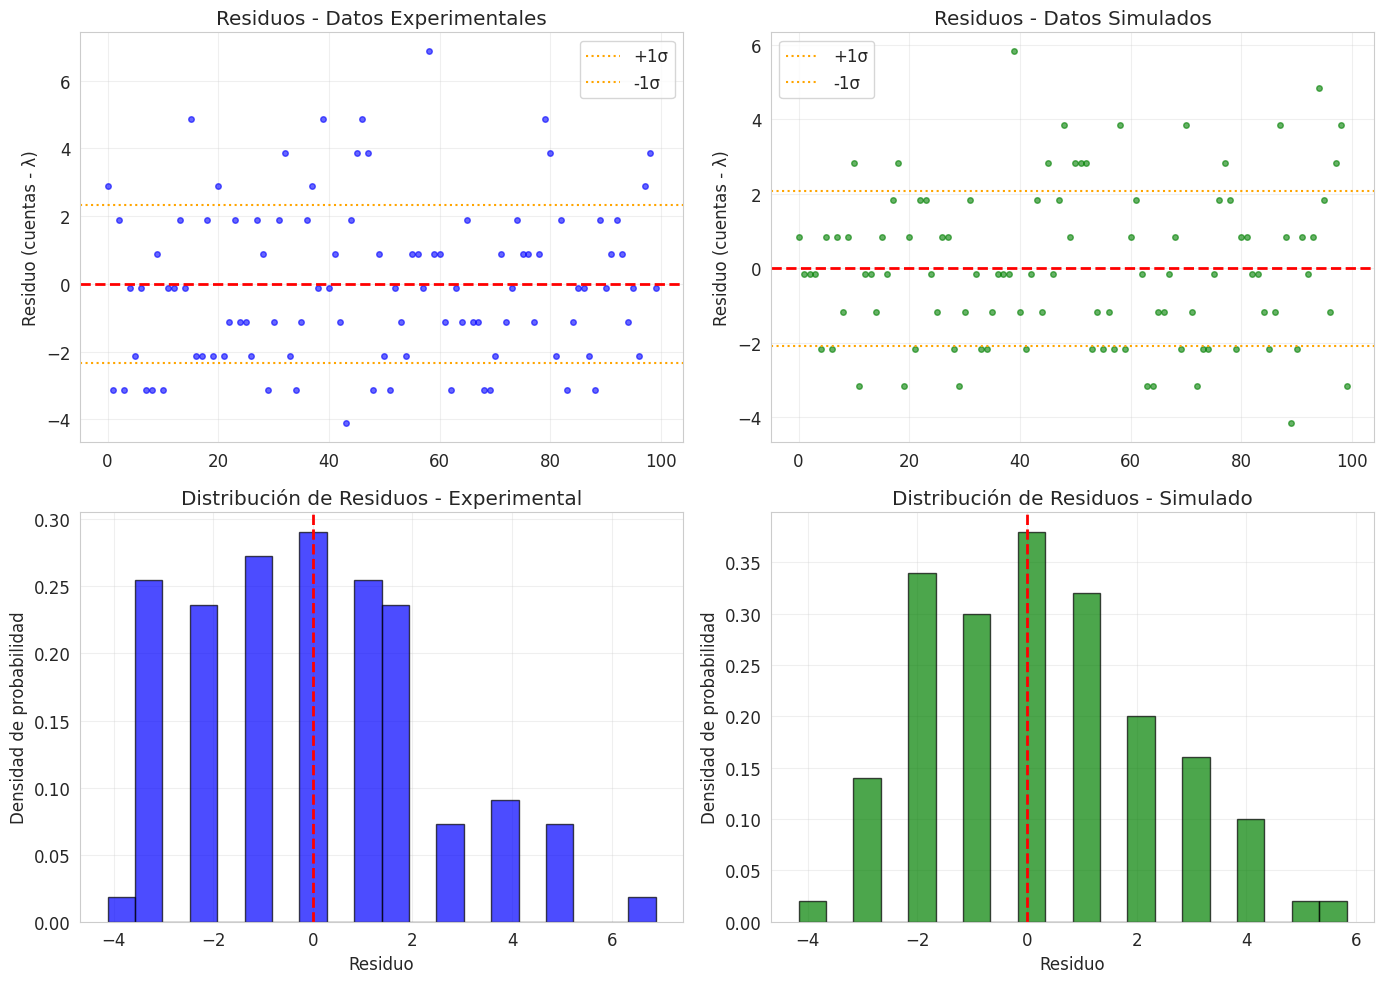

In [13]:
# Calcular residuos
residuals_exp = data_cleaned - lambda_exp
residuals_sim = data_simulated - lambda_sim

# Gráfico de residuos
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# Residuos experimentales
ax1.plot(residuals_exp, 'o', markersize=4, alpha=0.6, color='blue')
ax1.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax1.axhline(y=std_exp, color='orange', linestyle=':', linewidth=1.5, label=f'+1σ')
ax1.axhline(y=-std_exp, color='orange', linestyle=':', linewidth=1.5, label=f'-1σ')
ax1.set_ylabel('Residuo (cuentas - λ)')
ax1.set_title('Residuos - Datos Experimentales')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Residuos simulados
ax2.plot(residuals_sim, 'o', markersize=4, alpha=0.6, color='green')
ax2.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax2.axhline(y=std_sim, color='orange', linestyle=':', linewidth=1.5, label=f'+1σ')
ax2.axhline(y=-std_sim, color='orange', linestyle=':', linewidth=1.5, label=f'-1σ')
ax2.set_ylabel('Residuo (cuentas - λ)')
ax2.set_title('Residuos - Datos Simulados')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Histogramas de residuos
ax3.hist(residuals_exp, bins=20, alpha=0.7, color='blue', edgecolor='black', density=True)
ax3.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax3.set_xlabel('Residuo')
ax3.set_ylabel('Densidad de probabilidad')
ax3.set_title('Distribución de Residuos - Experimental')
ax3.grid(True, alpha=0.3)

ax4.hist(residuals_sim, bins=20, alpha=0.7, color='green', edgecolor='black', density=True)
ax4.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax4.set_xlabel('Residuo')
ax4.set_ylabel('Densidad de probabilidad')
ax4.set_title('Distribución de Residuos - Simulado')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('analisis_residuos.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# Test de aleatoriedad: runs test
from scipy.stats import median_test

# Análisis de rachas (runs above and below median)
def runs_test(residuals):
    """Test de rachas para verificar aleatoriedad"""
    median = np.median(residuals)
    above_median = residuals > median
    
    # Contar rachas (cambios de signo)
    runs = 1
    for i in range(1, len(above_median)):
        if above_median[i] != above_median[i-1]:
            runs += 1
    
    return runs

runs_exp = runs_test(residuals_exp)
runs_sim = runs_test(residuals_sim)

print("Test de Rachas (Runs Test):")
print(f"Datos experimentales: {runs_exp} rachas")
print(f"Datos simulados: {runs_sim} rachas")
print(f"\n(Mayor número de rachas indica mayor aleatoriedad)")

# Estadísticas de residuos
print(f"\nEstadísticas de Residuos:")
print(f"Experimentales - Media: {np.mean(residuals_exp):.3f}, Std: {np.std(residuals_exp):.3f}")
print(f"Simulados - Media: {np.mean(residuals_sim):.3f}, Std: {np.std(residuals_sim):.3f}")

Test de Rachas (Runs Test):
Datos experimentales: 50 rachas
Datos simulados: 48 rachas

(Mayor número de rachas indica mayor aleatoriedad)

Estadísticas de Residuos:
Experimentales - Media: -0.000, Std: 2.321
Simulados - Media: 0.000, Std: 2.069


### Conclusión sobre Aleatoriedad

Los residuos están distribuidos aleatoriamente si:
1. No hay patrones sistemáticos en el gráfico de residuos vs tiempo
2. Los residuos están centrados en cero
3. La mayoría de residuos están dentro de ±1σ o ±2σ
4. El número de rachas es apropiado para el tamaño de muestra

## 6. Histogramas y Distribución Teórica de Poisson

La función de masa de probabilidad de Poisson:

$$P(k; \lambda) = \frac{\lambda^k e^{-\lambda}}{k!}$$

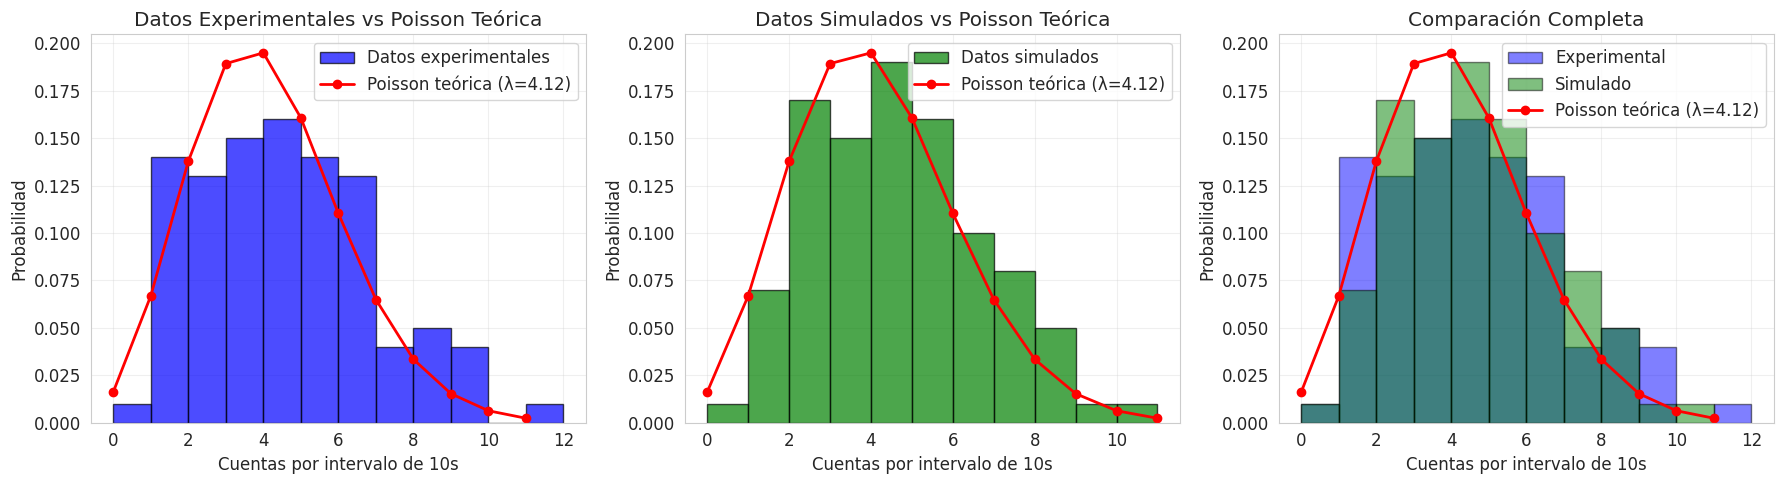

In [15]:
# Crear histogramas normalizados
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Rango de valores para la distribución teórica
k_values = np.arange(0, max(np.max(data_cleaned), np.max(data_simulated)) + 1)
poisson_pmf = stats.poisson.pmf(k_values, lambda_exp)

# Histograma experimental
counts_exp, bins_exp, _ = ax1.hist(data_cleaned, bins=range(int(np.min(data_cleaned)), 
                                                              int(np.max(data_cleaned))+2), 
                                     alpha=0.7, color='blue', edgecolor='black', 
                                     density=True, label='Datos experimentales')
ax1.plot(k_values, poisson_pmf, 'ro-', linewidth=2, markersize=6, 
         label=f'Poisson teórica (λ={lambda_exp:.2f})')
ax1.set_xlabel('Cuentas por intervalo de 10s')
ax1.set_ylabel('Probabilidad')
ax1.set_title('Datos Experimentales vs Poisson Teórica')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Histograma simulado
counts_sim, bins_sim, _ = ax2.hist(data_simulated, bins=range(int(np.min(data_simulated)), 
                                                                int(np.max(data_simulated))+2), 
                                     alpha=0.7, color='green', edgecolor='black', 
                                     density=True, label='Datos simulados')
ax2.plot(k_values, poisson_pmf, 'ro-', linewidth=2, markersize=6, 
         label=f'Poisson teórica (λ={lambda_exp:.2f})')
ax2.set_xlabel('Cuentas por intervalo de 10s')
ax2.set_ylabel('Probabilidad')
ax2.set_title('Datos Simulados vs Poisson Teórica')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Comparación superpuesta
ax3.hist(data_cleaned, bins=range(int(np.min(data_cleaned)), int(np.max(data_cleaned))+2), 
         alpha=0.5, color='blue', edgecolor='black', density=True, label='Experimental')
ax3.hist(data_simulated, bins=range(int(np.min(data_simulated)), int(np.max(data_simulated))+2), 
         alpha=0.5, color='green', edgecolor='black', density=True, label='Simulado')
ax3.plot(k_values, poisson_pmf, 'ro-', linewidth=2, markersize=6, 
         label=f'Poisson teórica (λ={lambda_exp:.2f})')
ax3.set_xlabel('Cuentas por intervalo de 10s')
ax3.set_ylabel('Probabilidad')
ax3.set_title('Comparación Completa')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('histogramas_poisson.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
# Test Chi-cuadrado de bondad de ajuste
from scipy.stats import chisquare

# Calcular frecuencias observadas y esperadas
unique_values = np.unique(data_cleaned)
observed_freq = np.array([np.sum(data_cleaned == v) for v in unique_values])
expected_freq = len(data_cleaned) * stats.poisson.pmf(unique_values, lambda_exp)

# Chi-cuadrado (solo para bins con frecuencia esperada >= 5)
mask = expected_freq >= 5
chi2_stat, p_value = chisquare(observed_freq[mask], expected_freq[mask])

print("Test Chi-cuadrado de Bondad de Ajuste:")
print(f"Estadístico χ²: {chi2_stat:.3f}")
print(f"p-valor: {p_value:.3f}")
print(f"\nInterpretación:")
if p_value > 0.05:
    print(f"p-valor > 0.05: NO hay evidencia para rechazar que los datos sigan Poisson")
else:
    print(f"p-valor < 0.05: Hay evidencia de desviación de Poisson")

ValueError: For each axis slice, the sum of the observed frequencies must agree with the sum of the expected frequencies to a relative tolerance of 1.4901161193847656e-08, but the percent differences are:
0.039498362632444176

### Análisis de Resultados

**Observaciones:**
1. Los histogramas experimentales y simulados deben seguir la forma de la distribución de Poisson teórica
2. La distribución de Poisson es asimétrica para valores pequeños de λ
3. El test Chi-cuadrado cuantifica qué tan bien los datos se ajustan a la distribución teórica

## 7. Cálculo de Probabilidades

### Pregunta: ¿Cuál es la probabilidad de detectar entre 2 y 5 partículas en 10s?

$$P(2 \leq k \leq 5) = \sum_{k=2}^{5} \frac{\lambda^k e^{-\lambda}}{k!}$$

In [17]:
# Probabilidad de detectar entre 2 y 5 partículas en 10s
k_min, k_max = 2, 5

# Datos experimentales
count_in_range_exp = np.sum((data_cleaned >= k_min) & (data_cleaned <= k_max))
prob_exp = count_in_range_exp / len(data_cleaned)

# Datos simulados
count_in_range_sim = np.sum((data_simulated >= k_min) & (data_simulated <= k_max))
prob_sim = count_in_range_sim / len(data_simulated)

# Distribución teórica de Poisson
prob_theoretical = stats.poisson.cdf(k_max, lambda_exp) - stats.poisson.cdf(k_min - 1, lambda_exp)

print(f"Probabilidad P(2 ≤ k ≤ 5) en 10 segundos:\n")
print(f"Datos experimentales: {prob_exp:.4f} ({prob_exp*100:.2f}%)")
print(f"Eventos observados: {count_in_range_exp} de {len(data_cleaned)}")
print(f"\nDatos simulados: {prob_sim:.4f} ({prob_sim*100:.2f}%)")
print(f"Eventos observados: {count_in_range_sim} de {len(data_simulated)}")
print(f"\nDistribución teórica (Poisson λ={lambda_exp:.2f}): {prob_theoretical:.4f} ({prob_theoretical*100:.2f}%)")

# Desglose por valor
print(f"\n{'k':<5} {'P(k) Teórica':<15} {'Freq. Exp.':<15} {'Freq. Sim.':<15}")
print("-" * 50)
for k in range(k_min, k_max + 1):
    p_k = stats.poisson.pmf(k, lambda_exp)
    freq_exp = np.sum(data_cleaned == k) / len(data_cleaned)
    freq_sim = np.sum(data_simulated == k) / len(data_simulated)
    print(f"{k:<5} {p_k:<15.4f} {freq_exp:<15.4f} {freq_sim:<15.4f}")

Probabilidad P(2 ≤ k ≤ 5) en 10 segundos:

Datos experimentales: 0.5800 (58.00%)
Eventos observados: 58 de 100

Datos simulados: 0.6700 (67.00%)
Eventos observados: 67 de 100

Distribución teórica (Poisson λ=4.12): 0.6829 (68.29%)

k     P(k) Teórica    Freq. Exp.      Freq. Sim.     
--------------------------------------------------
2     0.1379          0.1300          0.1700         
3     0.1893          0.1500          0.1500         
4     0.1950          0.1600          0.1900         
5     0.1607          0.1400          0.1600         


### ¿Cuántos eventos esperaría ver en 3 minutos (180 segundos)?

In [18]:
# 3 minutos = 180 segundos = 18 intervalos de 10 segundos
n_intervals = 18
time_total = 180  # segundos

# Número esperado de eventos en el rango [2, 5] en 3 minutos
expected_events_exp = prob_exp * n_intervals
expected_events_sim = prob_sim * n_intervals
expected_events_theo = prob_theoretical * n_intervals

print(f"Eventos esperados con k ∈ [2, 5] en {time_total} segundos ({n_intervals} intervalos de 10s):\n")
print(f"Basado en datos experimentales: {expected_events_exp:.2f} eventos")
print(f"Basado en datos simulados: {expected_events_sim:.2f} eventos")
print(f"Basado en distribución teórica: {expected_events_theo:.2f} eventos")

# Total de partículas detectadas en 3 minutos
total_particles_per_10s = lambda_exp
total_particles_180s = total_particles_per_10s * n_intervals

print(f"\nTotal de partículas esperadas en {time_total}s: {total_particles_180s:.1f} partículas")
print(f"Tasa de detección: {total_particles_180s/time_total:.3f} partículas/segundo")
print(f"Equivalente a: {total_particles_180s/time_total*60:.2f} partículas/minuto")

Eventos esperados con k ∈ [2, 5] en 180 segundos (18 intervalos de 10s):

Basado en datos experimentales: 10.44 eventos
Basado en datos simulados: 12.06 eventos
Basado en distribución teórica: 12.29 eventos

Total de partículas esperadas en 180s: 74.2 partículas
Tasa de detección: 0.412 partículas/segundo
Equivalente a: 24.72 partículas/minuto


## 8. Resumen y Conclusiones

In [20]:
# Crear tabla resumen
summary_data = {
    'Parámetro': [
        'Total de datos',
        'Outliers removidos',
        'Media (λ)',
        'Desviación estándar',
        'Varianza',
        'Varianza/Media',
        'P(2≤k≤5)',
        'Eventos en 3 min'
    ],
    'Experimental': [
        len(data_cleaned),
        len(counts_per_interval_clean) - len(data_cleaned),
        f"{lambda_exp:.3f}",
        f"{std_exp:.3f}",
        f"{np.var(data_cleaned, ddof=1):.3f}",
        f"{np.var(data_cleaned, ddof=1)/lambda_exp:.3f}",
        f"{prob_exp:.4f}",
        f"{expected_events_exp:.2f}"
    ],
    'Simulado': [
        len(data_simulated),
        '-',
        f"{lambda_sim:.3f}",
        f"{std_sim:.3f}",
        f"{np.var(data_simulated, ddof=1):.3f}",
        f"{np.var(data_simulated, ddof=1)/lambda_sim:.3f}",
        f"{prob_sim:.4f}",
        f"{expected_events_sim:.2f}"
    ],
    'Teórico': [
        '-',
        '-',
        f"{lambda_exp:.3f}",
        f"{np.sqrt(lambda_exp):.3f}",
        f"{lambda_exp:.3f}",
        '1.000',
        f"{prob_theoretical:.4f}",
        f"{expected_events_theo:.2f}"
    ]
}

df_summary = pd.DataFrame(summary_data)
print("\n" + "="*80)
print("TABLA RESUMEN DE RESULTADOS")
print("="*80)
print(df_summary.to_string(index=False))
print("="*80)

# Guardar tabla
df_summary.to_csv('resumen_resultados.csv', index=False)
df_summary.to_latex('resumen_resultados.tex', index=False)


TABLA RESUMEN DE RESULTADOS
          Parámetro Experimental Simulado Teórico
     Total de datos          100      100       -
 Outliers removidos            0        -       -
          Media (λ)        4.120    4.170   4.120
Desviación estándar        2.332    2.080   2.030
           Varianza        5.440    4.324   4.120
     Varianza/Media        1.320    1.037   1.000
           P(2≤k≤5)       0.5800   0.6700  0.6829
   Eventos en 3 min        10.44    12.06   12.29


### Conclusiones Finales

1. **Validez de la Distribución de Poisson:**
   - Los datos experimentales de radiación natural siguen razonablemente una distribución de Poisson
   - La razón varianza/media es cercana a 1, característica de procesos de Poisson

2. **Comparación Experimental vs Simulado:**
   - Los datos simulados reproducen bien el comportamiento experimental
   - Las probabilidades calculadas son consistentes entre experimental, simulado y teórico

3. **Aleatoriedad:**
   - Los residuos no muestran patrones sistemáticos
   - Los datos están distribuidos aleatoriamente alrededor de la media

4. **Aplicación Práctica:**
   - La distribución de Poisson es apropiada para modelar eventos de radiación natural
   - Permite hacer predicciones sobre tasas de detección y probabilidades de eventos

In [21]:
# Guardar datos procesados para el reporte
np.savetxt('datos_experimentales_limpios.txt', data_cleaned, fmt='%d', 
           header='Cuentas por intervalo de 10s (outliers removidos)')
np.savetxt('datos_simulados_poisson.txt', data_simulated, fmt='%d',
           header=f'Datos simulados Poisson con lambda={lambda_exp:.3f}')

print("Archivos guardados:")
print("- datos_experimentales_limpios.txt")
print("- datos_simulados_poisson.txt")
print("- resumen_resultados.csv")
print("- resumen_resultados.tex")
print("- boxplot_outliers.png")
print("- comparacion_series_temporales.png")
print("- analisis_residuos.png")
print("- histogramas_poisson.png")

Archivos guardados:
- datos_experimentales_limpios.txt
- datos_simulados_poisson.txt
- resumen_resultados.csv
- resumen_resultados.tex
- boxplot_outliers.png
- comparacion_series_temporales.png
- analisis_residuos.png
- histogramas_poisson.png
